# Dynamic Campaign Stopping

Monitor custom quantities and utilize them to dynamically decide to stop a campaign.

Find more information here:
- [Custom Hooks Basics](https://emdgroup.github.io/baybe/examples/Custom_Hooks/basics.html)
- [Monitor PI Evolution](https://emdgroup.github.io/baybe/examples/Custom_Hooks/probability_of_improvement.html)
- [Dynamically Stop Campaigns](https://emdgroup.github.io/baybe/examples/Custom_Hooks/campaign_stopping.html)
- [BayBE GitHub](https://github.com/emdgroup/baybe)
- [BayBE Userguide](https://emdgroup.github.io/baybe/userguide/userguide.html)

<a target="_blank" href="https://colab.research.google.com/github/emdgroup/baybe-ac24-workshop/blob/main/4_Dynamic_Campaign_Stopping.ipynb">
  <img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/>
</a>
<a target="_blank" href="https://mybinder.org/v2/gh/emdgroup/baybe-ac24-workshop/HEAD?labpath=4_Dynamic_Campaign_Stopping.ipynb">
  <img src="https://mybinder.org/badge_logo.svg" alt="Launch Binder"/>
</a>

# Install and Imports

In [1]:
!pip install 'baybe[chem,simulation]==0.10.0' seaborn matplotlib

In [ ]:
import warnings
from botorch.exceptions import InputDataWarning
warnings.filterwarnings('ignore', category = InputDataWarning)
warnings.filterwarnings('ignore', category = FutureWarning)
warnings.filterwarnings('ignore', message = '.*BayBE.*')

import baybe
baybe.__version__

In [3]:
from baybe.utils.random import set_random_seed
set_random_seed(123456)

import numpy as np
import torch
import matplotlib.pyplot as plt
import pandas as pd

# Use Hooks to Take a Detailed Look Into the Optimization

## Plotting Utility

In [4]:
from matplotlib.collections import PolyCollection
from mpl_toolkits.mplot3d import Axes3D
from scipy.stats import gaussian_kde
from baybe.utils.dataframe import to_tensor

def create_pi_plot(
    pi_per_iteration: list[np.ndarray],
) -> Axes3D:
    """Create the plot of the probability of improvement in 3D."""
    fig = plt.figure(figsize=(10,10))
    ax = fig.add_subplot(projection="3d")
    cmap = plt.get_cmap("viridis")
    pi_max = max([np.max(p) for p in pi_per_iteration])

    # Plot each PI array separately
    for i, p in enumerate(pi_per_iteration):
        x = np.linspace(0, pi_max, 500)
        y = gaussian_kde(p)(x)
        z = np.full_like(y, i)

        # Fill the area under the curve
        verts = [[(x[0], 0.0), *zip(x, y), (x[-1], 0.0)]]
        color = cmap(float(i) / len(pi_per_iteration))
        poly = PolyCollection(verts, color=color, alpha=1.0)
        ax.add_collection3d(poly, zs=i, zdir="x")
        
        ax.plot(x, y, z, zdir="x", color=color)

    # Set viewing angle, aspects and ;imits
    ax.view_init(elev=20, azim=25)
    ax.set_box_aspect([1.2, 1, 1])
    ax.set_ylim(0, pi_max)

    # Set axis ticks to have the correct iteration number
    ax.set_xticks(np.arange(0, len(pi_per_iteration), 1))
    ax.set_xticklabels([i for i in range(1, len(pi_per_iteration) + 1)])
    ax.set_ylabel("Probability of Improvement", labelpad=5)
    ax.set_xlabel("Iteration", labelpad=5)
    ax.set_zlabel("Density", labelpad=5)

    return ax

## Create a Hook: Store the PI of the entire Search Space

A hook is essentially a callable that we attach to methods of BayBE objects. For that, it needs to have `self` in its signature and can match any other signature arguments of the method it is attached to.

In this example we will attach our hook to `recommend` of `BotorchRecommender`. See here for the corresponding [signature](
https://emdgroup.github.io/baybe/_autosummary/baybe.recommenders.base.RecommenderProtocol.html#baybe.recommenders.base.RecommenderProtocol.recommend). Note how `batch_size` is ignored.

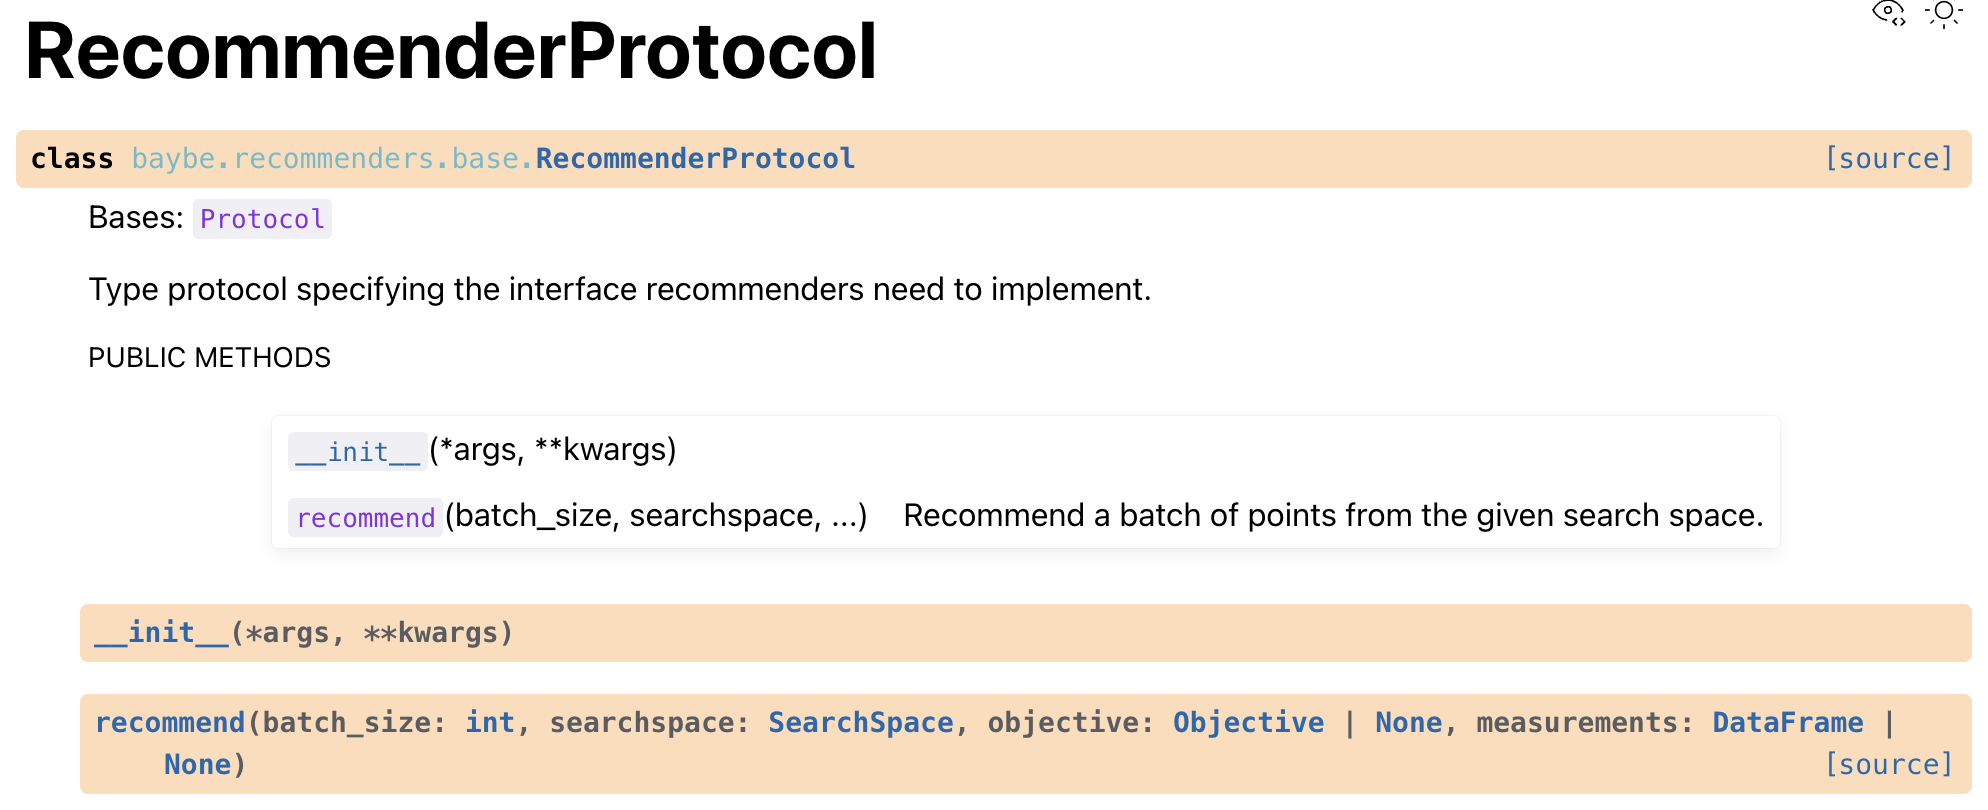

In [5]:
from baybe.recommenders import BotorchRecommender, RandomRecommender, TwoPhaseMetaRecommender
from baybe.utils import register_hooks

# We wills tore the PI per iteration to this global list
pi_per_iteration: list[np.ndarray] = []

def hook_extract_PI(
    self, # will be an instance of BotorchRecommender
    searchspace,
    objective = None,
    measurements = None,
) -> None:
    """Calculate and store the probability of improvement when called."""
    train_x = searchspace.transform(measurements, allow_extra=True)
    train_y = objective.transform(measurements)

    botorch_acqf = ProbabilityOfImprovement().to_botorch(self.surrogate_model, searchspace, train_x, train_y)
    comp_rep_tensor = to_tensor(searchspace.discrete.comp_rep).unsqueeze(1)
    with torch.no_grad():
        pi = botorch_acqf(comp_rep_tensor)
        
    pi_per_iteration.append(pi.numpy())

## Apply the Hook: Monkeypatch the Recommender

In [6]:
BotorchRecommender.recommend = register_hooks(
    BotorchRecommender.recommend,
    post_hooks=[hook_extract_PI],
)

## Run a Simulation (Hartmann3 Function)

We create a single campaign that optimizes the Hartmann3 function.

In [7]:
from baybe.acquisition import ProbabilityOfImprovement, qLogExpectedImprovement
from baybe.parameters import NumericalDiscreteParameter, SubstanceParameter
from baybe.objectives import SingleTargetObjective
from baybe.targets import NumericalTarget
from baybe.campaign import Campaign
from baybe.searchspace import SearchSpace

from botorch.test_functions.synthetic import Hartmann
from baybe.utils.botorch_wrapper import botorch_function_wrapper

POINTS_PER_DIM = 5
N_DOE_ITERATIONS = 7
DIMENSION = 3
BATCH_SIZE = 2

test_function = Hartmann(dim=DIMENSION)
WRAPPED_FUNCTION = botorch_function_wrapper(test_function=test_function)
BOUNDS = test_function.bounds

parameters = [
    NumericalDiscreteParameter(
        name=f"x{d}",
        values=np.linspace(lower, upper, POINTS_PER_DIM),
    )
    for d, (lower, upper) in enumerate(BOUNDS.T)
]
recommender = TwoPhaseMetaRecommender(
    initial_recommender=RandomRecommender(),
    recommender=BotorchRecommender(),
)

searchspace = SearchSpace.from_product(parameters=parameters)
objective = SingleTargetObjective(target=NumericalTarget(name="Target", mode="MIN"))
campaign = Campaign(
    searchspace=searchspace,
    recommender=recommender,
    objective=objective,
)

Run the campaign.

In [8]:
# Reset the PI list in case this is executed several times
pi_per_iteration = []

# Run a manual recommend-measure loop
for i in range(N_DOE_ITERATIONS):
    recommendation = campaign.recommend(BATCH_SIZE)
    target_values = recommendation.apply(WRAPPED_FUNCTION, axis=1)
    recommendation["Target"] = target_values
    campaign.add_measurements(recommendation)

Thanks to out hook, the probability of improvement of each point in the search space in each iteration was stored. We now use out utility to plot it.

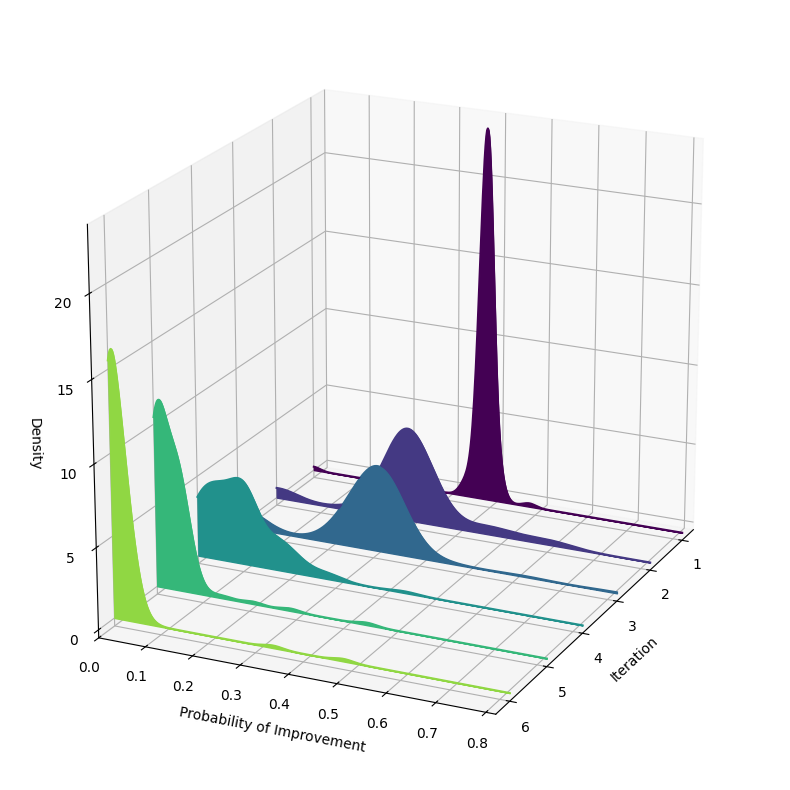

In [9]:
create_pi_plot(pi_per_iteration);

# Automatically Stop a Campaign When its no Longer Promising

## Create Hook: Terminate the Campaign

We will use the custom exception below to signal that a campaign should be terminated.

In [10]:
class CampaignStoppedException(Exception):
    """The campaign should be stopped."""

Now let us define the hook that implements the stopping logic. Similar to the first hook, we will attach it to the `.recommend` method of the `BotorchRecommender`.

In [11]:
PI_THRESHOLD = 0.05  # PI of 5% to identify still promising points
PI_REQUIRED_FRACTION = 0.5  # 50% of candidates must be over the threshold

def hook_stop_on_PI(
    self,
    searchspace,
    objective = None,
    measurements = None,
) -> None:
    """Raise an exception if the PI-based stopping criterion is fulfilled."""

    # Get training data and set up acuisition function
    train_x = searchspace.transform(measurements, allow_extra = True)
    train_y = objective.transform(measurements)
    acqf = ProbabilityOfImprovement()
    botorch_acqf = acqf.to_botorch(self.surrogate_model, searchspace, train_x, train_y)

    # Get all remaining candidates and their acqf value
    _, candidates_comp_rep = searchspace.discrete.get_candidates(
        allow_repeated_recommendations = self.allow_repeated_recommendations,
        allow_recommending_already_measured = self.allow_recommending_already_measured,
    )
    comp_rep_tensor = to_tensor(candidates_comp_rep).unsqueeze(1)
    acqf_values = botorch_acqf(comp_rep_tensor)

    # Apply our criterion and throw an exception
    n_pis_over = torch.sum(acqf_values > PI_THRESHOLD)
    n_pis_over_required = len(candidates_comp_rep) * PI_REQUIRED_FRACTION
    if n_pis_over < n_pis_over_required:
        raise CampaignStoppedException(
            f"Less than {PI_REQUIRED_FRACTION*100:.0f}% of candidates are above the PI "
            f"threshold of {PI_THRESHOLD*100:.0f}% - Stopping the campaign."
        )

## Create a Campaign to Show The Trajectory of Uninterrupted Runs

For this, we will use the same data set from [Shields, B.J., Stevens et al. Nature 590, 89–96 (2021)](https://doi.org/10.1038/s41586-021-03213-y) utilized previously.

In [12]:
url = 'https://raw.githubusercontent.com/emdgroup/baybe/main/examples/Backtesting/lookup.xlsx'
lookup = pd.read_excel(url, index_col=0)

solvent_data = dict(sorted(set(zip(lookup.Solvent, lookup.Solvent_SMILES))))
base_data = dict(sorted(set(zip(lookup.Base, lookup.Base_SMILES))))
ligand_data = dict(sorted(set(zip( lookup.Ligand, lookup.Ligand_SMILES))))
temperature_values = set(lookup.Temp_C)
concentration_values = set(lookup.Concentration)

parameters = [
    SubstanceParameter(name="Ligand", data = ligand_data),
    SubstanceParameter(name="Base", data = base_data),
    NumericalDiscreteParameter(name = "Temp_C", values = temperature_values),
    NumericalDiscreteParameter(name = "Concentration", values = concentration_values),
    SubstanceParameter(name = "Solvent", data = solvent_data),
]
objective = SingleTargetObjective(target=NumericalTarget(name="yield", mode="MAX"))

scenarios = {
    "Average uninterrupted": Campaign(
        searchspace = SearchSpace.from_product(parameters = parameters),
        objective = objective
    )
}

## Artificially Clip the Yields to Simulate a Scenario Where an Optimal Value is Not Reached

In [13]:
F_BEST = 80
lookup['yield'] = lookup['yield'].clip(upper = F_BEST)

In [14]:
from baybe.simulation import simulate_scenarios

N_DOE_ITERATIONS = 35
N_MC_ITERATIONS = 5
N_STOPPED_CAMPAIGNS = 5
BATCH_SIZE = 1

results_unstopped = simulate_scenarios(
    scenarios,
    lookup,
    batch_size = BATCH_SIZE,
    n_doe_iterations = N_DOE_ITERATIONS,
    n_mc_iterations = N_MC_ITERATIONS,
)

100%|###############################################################################################################################################################################| 5/5 [00:19<00:00,  3.90s/it]


## Now Also Perform Runs With Interrupted Campaigns

First, we attach the previously created hook to the recommender we intend to use.

In [15]:
BotorchRecommender.recommend = register_hooks(
    BotorchRecommender.recommend,
    post_hooks = [hook_stop_on_PI],
)

Now we run the simulations. When BayBE's simulation utility encounters an exception during the backtesting, it will still return partial results and instead print a `UserWarning` with the content of the exception. This enables us to see the full trajectory of the interrupted campaigns.

In [16]:
recommender_with_hook = TwoPhaseMetaRecommender(
    initial_recommender = RandomRecommender(),
    recommender = BotorchRecommender()
)

scenarios_interrupted = {
    "Interrupted": Campaign(
        searchspace = SearchSpace.from_product(parameters = parameters), 
        objective = objective, 
        recommender = recommender_with_hook
    )
}

results_stopped = simulate_scenarios(
    scenarios_interrupted,
    lookup,
    batch_size = BATCH_SIZE,
    n_doe_iterations = N_DOE_ITERATIONS,
    n_mc_iterations = N_STOPPED_CAMPAIGNS,
)

# Adjust the scenario label to separate the interrupted campaigns
results_stopped["Scenario"] = (
    results_stopped["Monte_Carlo_Run"]
    .rank(method = "dense")
    .astype(int)
    .apply(lambda k: f"PI-stopped, run {k}")
)

  0%|                                                                                                                                                                                       | 0/5 [00:00<?, ?it/s]/Users/m305221/Code/baybe/baybe/simulation/core.py:166: UserWarning: An error has occurred during the simulation, therefore incomplete simulation results are returned. The error message was:
Less than 50% of candidates are above the PI threshold of 5% - Stopping the campaign.
  warnings.warn(
 20%|###################################                                                                                                                                            | 1/5 [00:02<00:09,  2.26s/it]/Users/m305221/Code/baybe/baybe/simulation/core.py:166: UserWarning: An error has occurred during the simulation, therefore incomplete simulation results are returned. The error message was:
Less than 50% of candidates are above the PI threshold of 5% - Stopping the campaign.
  warning

## Plot the Results

We now compare the average uninterrupted campaign with 5 interrupted ones.

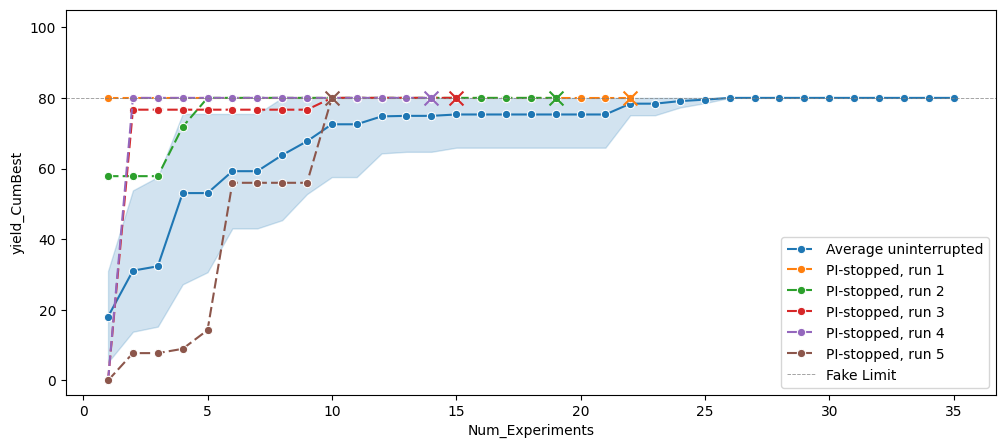

In [31]:
import seaborn as sns

results = pd.concat([results_unstopped, results_stopped])

ax = sns.lineplot(
    data = results,
    marker = "o",
    markersize = 6,
    x = "Num_Experiments",
    y = "yield_CumBest",
    hue = "Scenario",
)
plt.gca().set_ylim(plt.gca().get_ylim()[0], 100+5)
plt.axhline(y = F_BEST, color = 'grey', linestyle = '--', label = 'Fake Limit', linewidth=0.5)
for line in ax.get_lines()[1:]:
    line.set_dashes([5, 2])
    
# Add special marker to last point of interrupted campaigns
last_points = results.groupby('Scenario').tail(1)
for i, point in last_points[1:].iterrows():
    line_index = results['Scenario'].unique().tolist().index(point['Scenario'])
    ax.scatter(
        point['Num_Experiments'],
        point['yield_CumBest'],
        marker = 'x', s = 100,
        color = ax.get_lines()[line_index].get_color(),
        zorder = 999
    )

plt.legend()
plt.gcf().set_size_inches(12,5)

In this plot, the resulting campaign interruptions seem good - all campaigns stopped successfully after a near-optimal value has been found.

Playing around with different random seeds and settings, it seems that the criterion we devised earlier is still a little too strict. Especially for trajectories that have a lower than average performance in the beginning, the simple PI-based stopping terminates slightly too early.